In [1]:
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df_votants = pd.read_csv('database_deputes.csv', index_col=0)
df_votes = pd.read_csv('database_votes2.csv', index_col=0)

In [3]:
df_votes['vote'] = df_votes['vote'].replace({'Non-votant' : 'Nonvotant'})

In [4]:
#On récupère le groupe politique pour chaque député
groupe = df_votes[['idVotant', 'Groupe politique (complet)']].drop_duplicates()
groupe = groupe.set_index('idVotant')
groupe = groupe.rename(columns={'Groupe politique (complet)' : 'Groupe'})
groupe = groupe.replace('Mouvement Démocrate (MoDem) et Démocrates apparentés', 'MoDem et Démocrates apparentés')

# 1. Evolution des votes selon l'année

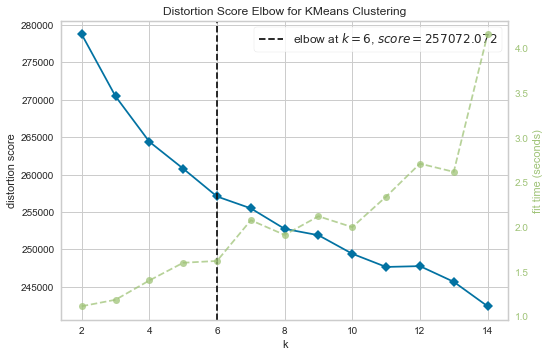

In [5]:
#On détermine d'abord le cluster de chaque député selon l'historique sur toute la période.
historique_vote = df_votes.copy()
historique_vote = historique_vote.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
#on remplace les NaN par de l'abstention (en confondant abstention et non-votant)
historique_vote = historique_vote.fillna('Non-votant')
historique_vote = pd.get_dummies(historique_vote, drop_first=True)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15), metric='distortion') 
visualizer.fit(historique_vote)       
visualizer.show() 

In [6]:
#La règle du coude a déterminé qu'il faut choisir 5 clusters : 
cluster_votes = historique_vote.copy() #refaire une copie à chaque fois !!!

N_CLUSTERS = 7
clustering = KMeans(n_clusters=N_CLUSTERS)
clustering.fit(cluster_votes)

#on détermine ensuite dans quel cluster chaque individu de df_cluster sera affecté :
pred = clustering.predict(cluster_votes)
cluster_votes['cluster'] = pred #on ajoute une colonne au df, qui indique le numéro du cluster auquel appartient chaque individu
cluster = cluster_votes[['cluster']]

In [7]:
#pour associer une couleur à un parti
color_dict = {'Socialistes et apparentés' : 'r',
              'Les Républicains' : 'b',
              'Non inscrit' : 'silver',
              'MoDem et Démocrates apparentés' : 'gold',
              'Libertés et Territoires' : 'dodgerblue', 
              'La France insoumise' : 'darkred',
              'La République en Marche' : 'darkorange', 
              'UDI et Indépendants' : 'cornflowerblue',
              'Gauche démocrate et républicaine' : 'tomato', 
              'Agir ensemble' : 'paleturquoise'}

## Votes de 2017

Variance: [0.06714825 0.06045392 0.03544268 0.02378676 0.02174127 0.01855657
 0.01590101 0.01510821 0.01396841 0.01172974]
Variance totale: 0.28383683828396555


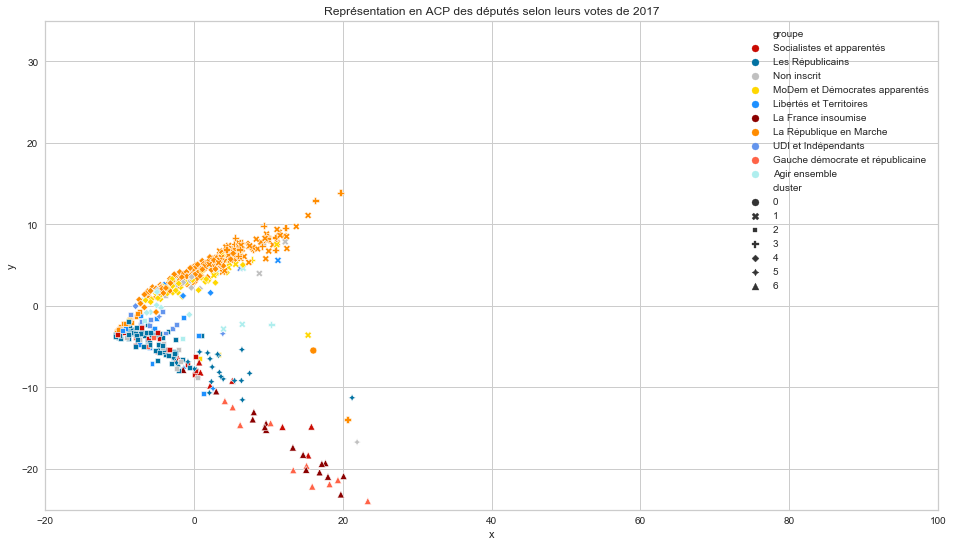

In [8]:
votes_2017 = df_votes[df_votes.date_scrutin < "2018-01-01"].copy()
votes_2017 = votes_2017.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
#on remplace les NaN par de l'abstention (en confondant abstention et non-votant)
votes_2017 = votes_2017.fillna('Nonvotant')
votes_2017 = pd.get_dummies(votes_2017, drop_first=True)

cluster_2017 = votes_2017.copy() #refaire une copie à chaque fois !!!
cluster_2017 = cluster_2017.merge(cluster, on='idVotant', how='left')
cluster_2017 = cluster_2017.merge(groupe, on='idVotant', how='left')
        
###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2017.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2017.Groupe]
cluster_2017['labels'] = labels
cluster_2017_acp = cluster_2017.drop(['cluster', 'labels','Groupe'], axis=1)

votes_2017_transform = StandardScaler().fit_transform(cluster_2017_acp)
pca = PCA(n_components=10).fit(votes_2017_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2017_transform)
x_2017 = resultats_reduced[:, 0]
y_2017 = resultats_reduced[:, 1]
y_2017 = -(y_2017)

df_plot_2017 = pd.DataFrame(dict(x=x_2017, y=y_2017, label=labels))
df_plot_2017['groupe'] = df_plot_2017['label'].replace(labels_to_groupe)
df_plot_2017 = pd.merge(df_plot_2017, cluster_2017[['cluster']].reset_index(drop=True), left_index=True, right_index=True)


plt.figure(figsize=(16,9))
plt.ylim([-25, 35])
plt.xlim([-20, 100])
plt.title('Représentation en ACP des députés selon leurs votes de 2017')
g = sns.scatterplot(data=df_plot_2017, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)
plt.legend(loc='upper right')
plt.savefig('votes_2017.png')
plt.savefig('2votes_2017.png')
plt.savefig('3votes_2017.png')
plt.savefig('4votes_2017.png')

In [9]:
x_2017 = -(x_2017)
x_2017

array([ 2.28825235e+00,  3.82641915e+00,  8.99338497e+00,  2.51974299e+00,
        6.21414132e+00,  6.24086348e+00,  5.38632763e+00, -5.60131122e-04,
        8.36386017e+00,  2.74950493e+00,  4.93146602e+00,  5.99293363e+00,
       -6.50424437e+00, -7.89428379e+00,  6.21976148e+00,  8.44018833e+00,
        5.90268835e+00,  4.77791459e+00,  8.55216551e+00,  7.32109929e+00,
       -3.00705075e-01,  6.00414784e+00,  4.16510862e+00,  1.54737792e+00,
        4.59580330e+00,  4.30053569e+00,  6.28417943e+00,  7.38295329e+00,
        6.76241548e+00,  4.21753796e+00, -5.19856777e+00,  6.69742529e+00,
        7.32594623e+00,  7.23543424e+00,  1.04109546e+01,  6.97151880e+00,
        6.20252538e+00,  5.99943566e+00,  4.28853179e+00,  7.63962684e+00,
        4.34722955e+00,  4.96597875e+00,  2.84785563e+00, -6.48631915e+00,
        4.95209387e+00,  8.74838389e+00,  6.36029693e+00,  7.19717808e+00,
        9.11147486e+00,  4.86798739e+00,  7.85149324e+00, -1.00539859e+00,
        2.16418408e+00,  

## Votes de 2018

Variance: [0.05682341 0.04623219 0.02860758 0.02736498 0.01978974 0.01753786
 0.01704217 0.01471759 0.01327182 0.01226903]
Variance totale: 0.2536563605190974


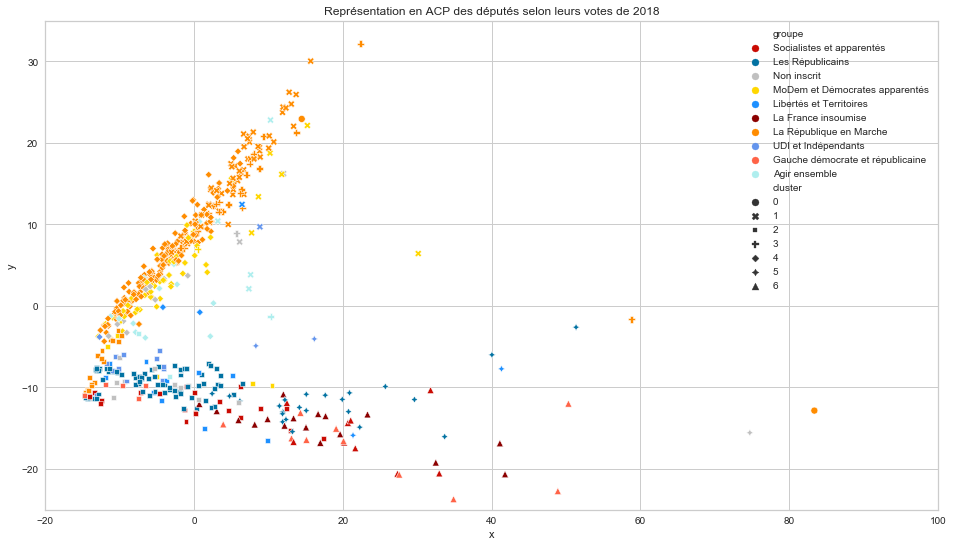

In [10]:
votes_2018 = df_votes[(df_votes.date_scrutin >= "2018-01-01") & (df_votes.date_scrutin < "2019-01-01")].copy()
votes_2018 = votes_2018.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
#on remplace les NaN par de l'abstention (en confondant abstention et non-votant)
votes_2018 = votes_2018.fillna('Nonvotant')
votes_2018 = pd.get_dummies(votes_2018, drop_first=True)
cluster_2018 = votes_2018.copy() #refaire une copie à chaque fois !!!
cluster_2018 = cluster_2018.merge(cluster, on='idVotant', how='left')
cluster_2018 = cluster_2018.merge(groupe, on='idVotant', how='left')


###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2018.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2018.Groupe]
cluster_2018['labels'] = labels
cluster_2018_acp = cluster_2018.drop(['cluster', 'labels','Groupe'], axis=1)

votes_2018_transform = StandardScaler().fit_transform(cluster_2018_acp)
pca = PCA(n_components=10).fit(votes_2018_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2018_transform)
x_2018 = resultats_reduced[:, 0]
y_2018 = resultats_reduced[:, 1]

df_plot_2018 = pd.DataFrame(dict(x=x_2018, y=y_2018, label=labels))
df_plot_2018['groupe'] = df_plot_2018['label'].replace(labels_to_groupe)
df_plot_2018 = pd.merge(df_plot_2018, cluster_2018[['cluster']].reset_index(drop=True), left_index=True, right_index=True)
    
plt.figure(figsize=(16,9))  
plt.ylim([-25, 35])
plt.xlim([-20, 100])
plt.title('Représentation en ACP des députés selon leurs votes de 2018')
g = sns.scatterplot(data=df_plot_2018, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)
plt.legend(loc='upper right')
plt.savefig('votes_2018.png')
plt.savefig('2votes_2018.png')
plt.savefig('3votes_2018.png')
plt.savefig('4votes_2018.png')

## Votes de 2019

Variance: [0.05660063 0.04226398 0.02389554 0.02358514 0.01872002 0.01525466
 0.01477856 0.01447011 0.01274796 0.0116071 ]
Variance totale: 0.23392370727155715


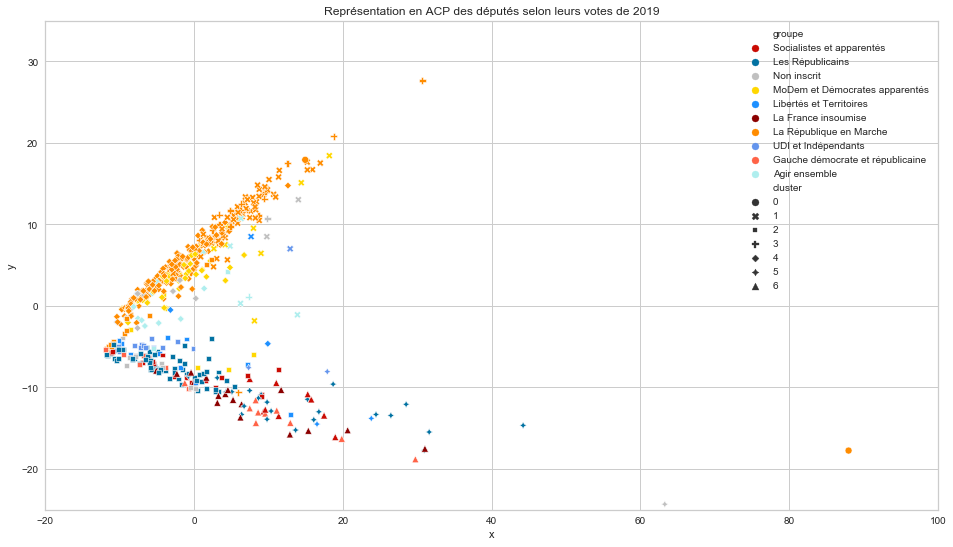

In [11]:
votes_2019 = df_votes[(df_votes.date_scrutin >= "2019-01-01") & (df_votes.date_scrutin < "2020-01-01")].copy()
votes_2019 = votes_2019.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
#on remplace les NaN par de l'abstention (en confondant abstention et non-votant)
votes_2019 = votes_2019.fillna('Nonvotant')
votes_2019 = pd.get_dummies(votes_2019, drop_first=True)
cluster_2019 = votes_2019.copy() #refaire une copie à chaque fois !!!
cluster_2019 = cluster_2019.merge(cluster, on='idVotant', how='left')
cluster_2019 = cluster_2019.merge(groupe, on='idVotant', how='left')


###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2019.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2019.Groupe]
cluster_2019['labels'] = labels
cluster_2019_acp = cluster_2019.drop(['cluster', 'labels','Groupe'], axis=1)

votes_2019_transform = StandardScaler().fit_transform(cluster_2019_acp)
pca = PCA(n_components=10).fit(votes_2019_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2019_transform)
x_2019 = resultats_reduced[:, 0]
y_2019 = resultats_reduced[:, 1]

df_plot_2019 = pd.DataFrame(dict(x=x_2019, y=y_2019, label=labels))
df_plot_2019['groupe'] = df_plot_2019['label'].replace(labels_to_groupe)
df_plot_2019 = pd.merge(df_plot_2019, cluster_2019[['cluster']].reset_index(drop=True), left_index=True, right_index=True)
    
plt.figure(figsize=(16,9))    
plt.ylim([-25, 35])
plt.xlim([-20, 100])
plt.title('Représentation en ACP des députés selon leurs votes de 2019')
g = sns.scatterplot(data=df_plot_2019, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)
plt.legend(loc='upper right')
plt.savefig('votes_2019.png')
plt.savefig('2votes_2019.png')
plt.savefig('3votes_2019.png')
plt.savefig('4votes_2019.png')

## Votes de 2020

Variance: [0.06684645 0.05397193 0.02905083 0.0202774  0.01654864 0.01578337
 0.01468745 0.01431133 0.01351209 0.01185564]
Variance totale: 0.2568451296918625


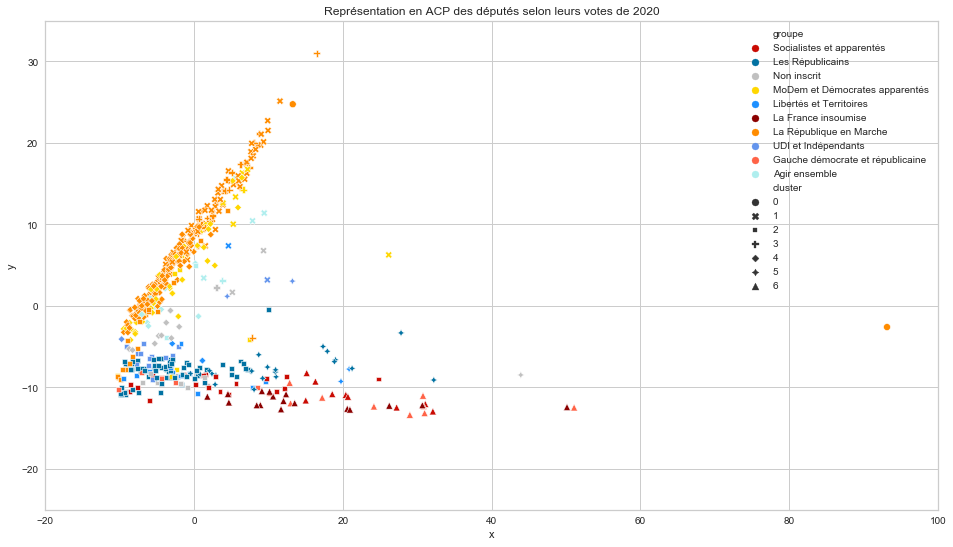

In [12]:
votes_2020 = df_votes[df_votes.date_scrutin >= "2020-01-01"].copy()

votes_2020 = votes_2020.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
#on remplace les NaN par de l'abstention (en confondant abstention et non-votant)
votes_2020 = votes_2020.fillna('Nonvotant')
votes_2020 = pd.get_dummies(votes_2020, drop_first=True)
cluster_2020 = votes_2020.copy() #refaire une copie à chaque fois !!!
cluster_2020 = cluster_2020.merge(cluster, on='idVotant', how='left')
cluster_2020 = cluster_2020.merge(groupe, on='idVotant', how='left')


###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2020.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2020.Groupe]
cluster_2020['labels'] = labels
cluster_2020_acp = cluster_2020.drop(['cluster', 'labels','Groupe'], axis=1)

votes_2020_transform = StandardScaler().fit_transform(cluster_2020_acp)
pca = PCA(n_components=10).fit(votes_2020_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2020_transform)
x_2020 = resultats_reduced[:, 0]
y_2020 = resultats_reduced[:, 1]

df_plot_2020 = pd.DataFrame(dict(x=x_2020, y=y_2020, label=labels))
df_plot_2020['groupe'] = df_plot_2020['label'].replace(labels_to_groupe)
df_plot_2020 = pd.merge(df_plot_2020, cluster_2020[['cluster']].reset_index(drop=True), left_index=True, right_index=True)
    
plt.figure(figsize=(16,9))    
plt.ylim([-25, 35])
plt.xlim([-20, 100])
plt.title('Représentation en ACP des députés selon leurs votes de 2020')
g = sns.scatterplot(data=df_plot_2020, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)
plt.legend(loc='upper right')
plt.savefig('votes_2020.png')
plt.savefig('2votes_2020.png')
plt.savefig('3votes_2020.png')
plt.savefig('4votes_2020.png')

In [13]:
import imageio 
images = [] 
filenames=['votes_2017.png', '2votes_2017.png', '3votes_2017.png', '4votes_2017.png',
           'votes_2018.png', '2votes_2018.png', '3votes_2018.png', '4votes_2018.png',
           'votes_2019.png', '2votes_2019.png', '3votes_2019.png', '4votes_2019.png',
           'votes_2020.png', '2votes_2020.png', '3votes_2020.png', '4votes_2020.png'] 
for filename in filenames: 
    images.append(imageio.imread(filename)) 
    imageio.mimsave('vote.gif', images)
plt.clf()
from IPython.display import Image
display(Image(url='vote.gif'))

<Figure size 576x396 with 0 Axes>

# 2. Evolution des indices

In [14]:
#Indices

proportion_vote = pd.read_csv('proportion_vote.csv', index_col=0)

indice_accord = pd.read_csv('indice_accord.csv', index_col=0)
indice_accord = indice_accord[['idVotant', 'IndiceAccord']]
indice_accord = indice_accord.rename(columns={'IndiceAccord' : 'indice_accord'})

participation = df_votes.groupby('idVotant').count()
participation['taux_participation'] = participation['idScrutin']/3117*100
participation = participation[['taux_participation']]

df_indices = proportion_vote.merge(indice_accord, on='idVotant', how='left')
df_indices = df_indices.merge(participation, on='idVotant', how='left')
df_indices = df_indices.set_index('idVotant')
df_indices

,Contre,Pour,indice_accord,taux_participation
idVotant,,,,
PA1008,31.162791,68.837209,31.937984,20.692974
PA1012,34.131737,65.868263,37.425150,10.715432
PA1029,51.818182,48.181818,43.636364,3.529034
PA1198,33.234421,66.765579,32.047478,10.811678
PA1206,45.454545,54.545455,28.409091,5.646455
...,...,...,...,...
PA774962,80.000000,20.000000,40.000000,0.160411
PA856,42.780749,57.219251,38.770053,11.998717
PA923,41.991342,58.008658,40.259740,7.410972


In [15]:
cluster_indices = df_indices.copy() #refaire une copie à chaque fois !!!

N_CLUSTERS = 2
clustering = KMeans(n_clusters=N_CLUSTERS)
clustering.fit(cluster_indices)

#on détermine ensuite dans quel cluster chaque individu de df_cluster sera affecté :
pred = clustering.predict(cluster_indices)
df_indices['cluster'] = pred #on ajoute une colonne au df, qui indique le numéro du cluster auquel appartient chaque individu

### 2017

In [16]:
votes_2017 = df_votes[df_votes.date_scrutin < "2018-01-01"].copy()

#taux de participation
nb_votes_2017 = votes_2017['idScrutin'].nunique()
participation_2017 = votes_2017.groupby('idVotant').count()
participation_2017['taux_participation'] = participation_2017['idScrutin']/(nb_votes_2017)*100
participation_2017 = participation_2017[['taux_participation']]

#proportion vote
avis_votant_2017 = pd.DataFrame(votes_2017.groupby(['idVotant']).vote.value_counts())
avis_votant_2017 = avis_votant_2017.rename(columns={'vote':'nombre'})
total_votant_2017 = votes_2017.groupby(['idVotant']).vote.count()
proportion_2017 = pd.DataFrame({'Proportion' : np.round(avis_votant_2017['nombre'].div(total_votant_2017)*100, decimals=2)})
proportion_2017 = proportion_2017.unstack()
proportion_2017.columns = proportion_2017.columns.droplevel()
proportion_2017 = proportion_2017.drop('Nonvotant', axis=1)
proportion_2017 = proportion_2017.fillna(0)

#indice accord
partis = pd.DataFrame(votes_2017.groupby('idVotant')['organeRefGroupe'].unique())
df_2017 = votes_2017[((votes_2017.vote == 'Pour') & (votes_2017.resultat == 'adopté')) | ((votes_2017.vote == 'Contre') & (votes_2017.resultat == 'rejeté'))]
accord_votant = df_2017.idVotant.value_counts() 
total_votant = votes_2017.idVotant.value_counts()
indice_accord_2017 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2017.index = indice_accord_2017.index.rename('idVotant')

#df final
indices_2017 = proportion_2017.merge(indice_accord_2017, on='idVotant', how='left')
indices_2017 = indices_2017.merge(participation_2017, on='idVotant', how='left')
indices_2017 = indices_2017.fillna(0)

Variance: [0.7278869  0.20174624 0.06541455 0.00495231]
Variance totale: 1.0


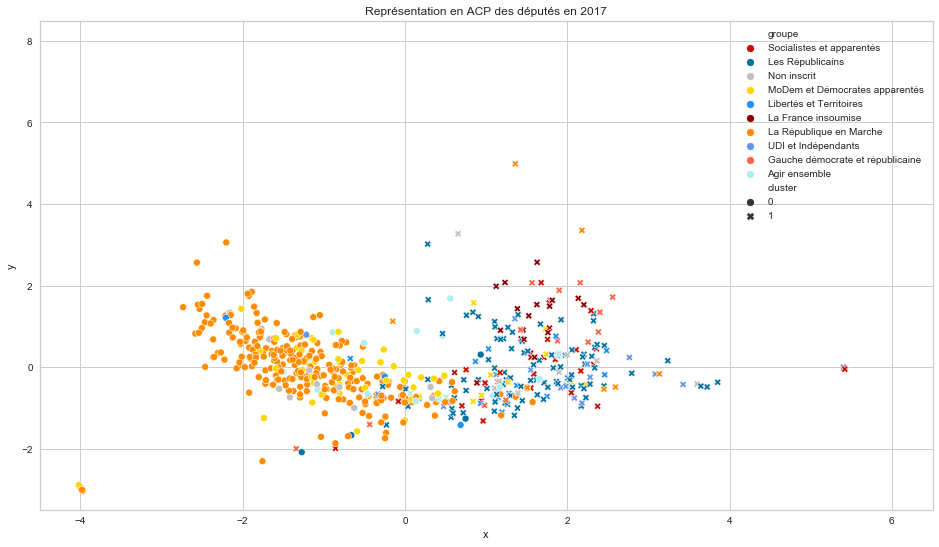

In [17]:
indices_2017 = indices_2017.merge(df_indices[['cluster']], on='idVotant', how='left')
cluster = indices_2017[['cluster']]
indices_2017 = indices_2017.merge(groupe, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2017.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2017.Groupe]
indices_2017['labels'] = labels
indices_2017_acp = indices_2017.drop(['cluster', 'labels','Groupe'], axis=1)

indices_2017_transform = StandardScaler().fit_transform(indices_2017_acp)
pca = PCA(n_components=4).fit(indices_2017_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2017_transform)
x_2017 = resultats_reduced[:, 0]
y_2017 = resultats_reduced[:, 1]

df_plot_2017 = pd.DataFrame(dict(x=x_2017, y=y_2017, label=labels))
df_plot_2017['groupe'] = df_plot_2017['label'].replace(labels_to_groupe)
df_plot_2017 = pd.merge(df_plot_2017, indices_2017[['cluster']].reset_index(drop=True), left_index=True, right_index=True)

plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])
plt.title('Représentation en ACP des députés en 2017')
g = sns.scatterplot(data=df_plot_2017, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)
plt.legend(loc='upper right')
plt.savefig('indices_2017.png')
plt.savefig('2indices_2017.png')
plt.savefig('3indices_2017.png')
plt.savefig('4indices_2017.png')

### 2018

In [18]:
votes_2018 = df_votes[(df_votes.date_scrutin >= "2018-01-01") & (df_votes.date_scrutin < "2019-01-01")].copy()

#taux de participation
nb_votes_2018 = votes_2018['idScrutin'].nunique()
participation_2018 = votes_2018.groupby('idVotant').count()
participation_2018['taux_participation'] = participation_2018['idScrutin']/(nb_votes_2018)*100
participation_2018 = participation_2018[['taux_participation']]

#proportion vote
avis_votant_2018 = pd.DataFrame(votes_2018.groupby(['idVotant']).vote.value_counts())
avis_votant_2018 = avis_votant_2018.rename(columns={'vote':'nombre'})
total_votant_2018 = votes_2018.groupby(['idVotant']).vote.count()
proportion_2018 = pd.DataFrame({'Proportion' : np.round(avis_votant_2018['nombre'].div(total_votant_2018)*100, decimals=2)})
proportion_2018 = proportion_2018.unstack()
proportion_2018.columns = proportion_2018.columns.droplevel()
proportion_2018 = proportion_2018.drop('Nonvotant', axis=1)
proportion_2018 = proportion_2018.fillna(0)

#indice accord
partis = pd.DataFrame(votes_2018.groupby('idVotant')['organeRefGroupe'].unique())
df_2018 = votes_2018[((votes_2018.vote == 'Pour') & (votes_2018.resultat == 'adopté')) | ((votes_2018.vote == 'Contre') & (votes_2018.resultat == 'rejeté'))]
accord_votant = df_2018.idVotant.value_counts() 
total_votant = votes_2018.idVotant.value_counts()
indice_accord_2018 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2018.index = indice_accord_2018.index.rename('idVotant')

#df final
indices_2018 = proportion_2018.merge(indice_accord_2018, on='idVotant', how='left')
indices_2018 = indices_2018.merge(participation_2018, on='idVotant', how='left')
indices_2018 = indices_2018.fillna(0)

Variance: [0.73834119 0.21813581 0.03900146 0.00452154]
Variance totale: 1.0


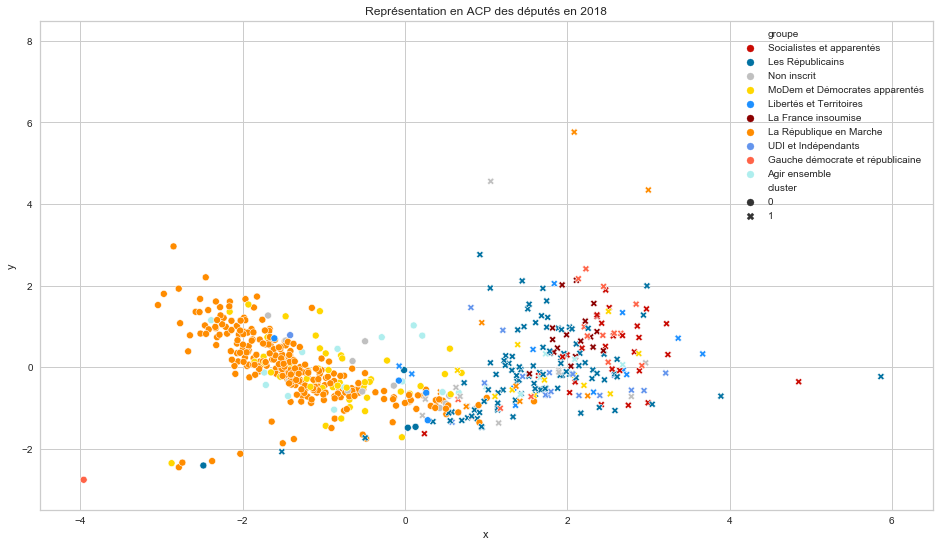

In [19]:
indices_2018 = indices_2018.merge(df_indices[['cluster']], on='idVotant', how='left')
cluster = indices_2018[['cluster']]
indices_2018 = indices_2018.merge(groupe, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2018.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2018.Groupe]
indices_2018['labels'] = labels
indices_2018_acp = indices_2018.drop(['cluster', 'labels','Groupe'], axis=1)

indices_2018_transform = StandardScaler().fit_transform(indices_2018_acp)
pca = PCA(n_components=4).fit(indices_2018_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2018_transform)
x_2018 = resultats_reduced[:, 0]
y_2018 = resultats_reduced[:, 1]

df_plot_2018 = pd.DataFrame(dict(x=x_2018, y=y_2018, label=labels))
df_plot_2018['groupe'] = df_plot_2018['label'].replace(labels_to_groupe)
df_plot_2018 = pd.merge(df_plot_2018, indices_2018[['cluster']].reset_index(drop=True), left_index=True, right_index=True)

plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])
plt.title('Représentation en ACP des députés en 2018')
g = sns.scatterplot(data=df_plot_2018, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)
plt.legend(loc='upper right')
plt.savefig('indices_2018.png')
plt.savefig('2indices_2018.png')
plt.savefig('3indices_2018.png')
plt.savefig('4indices_2018.png')

### 2019

In [20]:
votes_2019 = df_votes[(df_votes.date_scrutin >= "2019-01-01") & (df_votes.date_scrutin < "2020-01-01")].copy()

#taux de participation
nb_votes_2019 = votes_2019['idScrutin'].nunique()
participation_2019 = votes_2019.groupby('idVotant').count()
participation_2019['taux_participation'] = participation_2019['idScrutin']/(nb_votes_2019)*100
participation_2019 = participation_2019[['taux_participation']]

#proportion vote
avis_votant_2019 = pd.DataFrame(votes_2019.groupby(['idVotant']).vote.value_counts())
avis_votant_2019 = avis_votant_2019.rename(columns={'vote':'nombre'})
total_votant_2019 = votes_2019.groupby(['idVotant']).vote.count()
proportion_2019 = pd.DataFrame({'Proportion' : np.round(avis_votant_2019['nombre'].div(total_votant_2019)*100, decimals=2)})
proportion_2019 = proportion_2019.unstack()
proportion_2019.columns = proportion_2019.columns.droplevel()
proportion_2019 = proportion_2019.drop('Nonvotant', axis=1)
proportion_2019 = proportion_2019.fillna(0)

#indice accord
partis = pd.DataFrame(votes_2019.groupby('idVotant')['organeRefGroupe'].unique())
df_2019 = votes_2019[((votes_2019.vote == 'Pour') & (votes_2019.resultat == 'adopté')) | ((votes_2019.vote == 'Contre') & (votes_2019.resultat == 'rejeté'))]
accord_votant = df_2019.idVotant.value_counts() 
total_votant = votes_2019.idVotant.value_counts()
indice_accord_2019 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2019.index = indice_accord_2019.index.rename('idVotant')

#df final
indices_2019 = proportion_2019.merge(indice_accord_2019, on='idVotant', how='left')
indices_2019 = indices_2019.merge(participation_2019, on='idVotant', how='left')
indices_2019 = indices_2019.fillna(0)

Variance: [0.68435533 0.20948705 0.09952557 0.00663204]
Variance totale: 1.0000000000000002


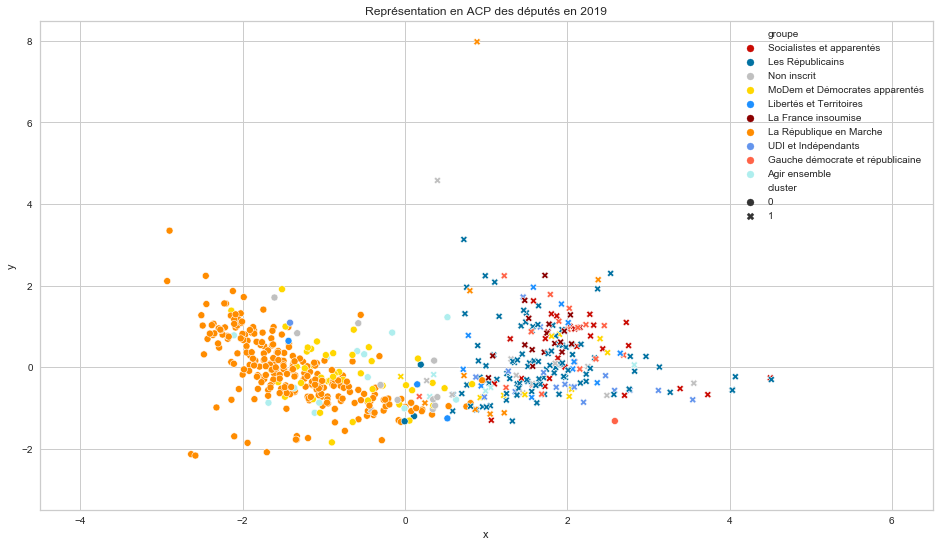

In [21]:
indices_2019 = indices_2019.merge(df_indices[['cluster']], on='idVotant', how='left')
cluster = indices_2019[['cluster']]
indices_2019 = indices_2019.merge(groupe, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2019.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2019.Groupe]
indices_2019['labels'] = labels
indices_2019_acp = indices_2019.drop(['cluster', 'labels','Groupe'], axis=1)

indices_2019_transform = StandardScaler().fit_transform(indices_2019_acp)
pca = PCA(n_components=4).fit(indices_2019_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2019_transform)
x_2019 = resultats_reduced[:, 0]
y_2019 = resultats_reduced[:, 1]

df_plot_2019 = pd.DataFrame(dict(x=x_2019, y=y_2019, label=labels))
df_plot_2019['groupe'] = df_plot_2019['label'].replace(labels_to_groupe)
df_plot_2019 = pd.merge(df_plot_2019, indices_2019[['cluster']].reset_index(drop=True), left_index=True, right_index=True)

plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])
plt.title('Représentation en ACP des députés en 2019')
g = sns.scatterplot(data=df_plot_2019, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)
plt.legend(loc='upper right')
plt.savefig('indices_2019.png')
plt.savefig('2indices_2019.png')
plt.savefig('3indices_2019.png')
plt.savefig('4indices_2019.png')

### 2020

In [22]:
votes_2020 = df_votes[df_votes.date_scrutin >= "2020-01-01"].copy()

#taux de participation
nb_votes_2020 = votes_2020['idScrutin'].nunique()
participation_2020 = votes_2020.groupby('idVotant').count()
participation_2020['taux_participation'] = participation_2020['idScrutin']/(nb_votes_2020)*100
participation_2020 = participation_2020[['taux_participation']]

#proportion vote
avis_votant_2020 = pd.DataFrame(votes_2020.groupby(['idVotant']).vote.value_counts())
avis_votant_2020 = avis_votant_2020.rename(columns={'vote':'nombre'})
total_votant_2020 = votes_2020.groupby(['idVotant']).vote.count()
proportion_2020 = pd.DataFrame({'Proportion' : np.round(avis_votant_2020['nombre'].div(total_votant_2020)*100, decimals=2)})
proportion_2020 = proportion_2020.unstack()
proportion_2020.columns = proportion_2020.columns.droplevel()
proportion_2020 = proportion_2020.drop('Nonvotant', axis=1)
proportion_2020 = proportion_2020.fillna(0)

#indice accord
partis = pd.DataFrame(votes_2020.groupby('idVotant')['organeRefGroupe'].unique())
df_2020 = votes_2020[((votes_2020.vote == 'Pour') & (votes_2020.resultat == 'adopté')) | ((votes_2020.vote == 'Contre') & (votes_2020.resultat == 'rejeté'))]
accord_votant = df_2020.idVotant.value_counts() 
total_votant = votes_2020.idVotant.value_counts()
indice_accord_2020 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2020.index = indice_accord_2020.index.rename('idVotant')

#df final
indices_2020 = proportion_2020.merge(indice_accord_2020, on='idVotant', how='left')
indices_2020 = indices_2020.merge(participation_2020, on='idVotant', how='left')
indices_2020 = indices_2020.fillna(0)

Variance: [0.74232968 0.20485034 0.0492964  0.00352357]
Variance totale: 1.0


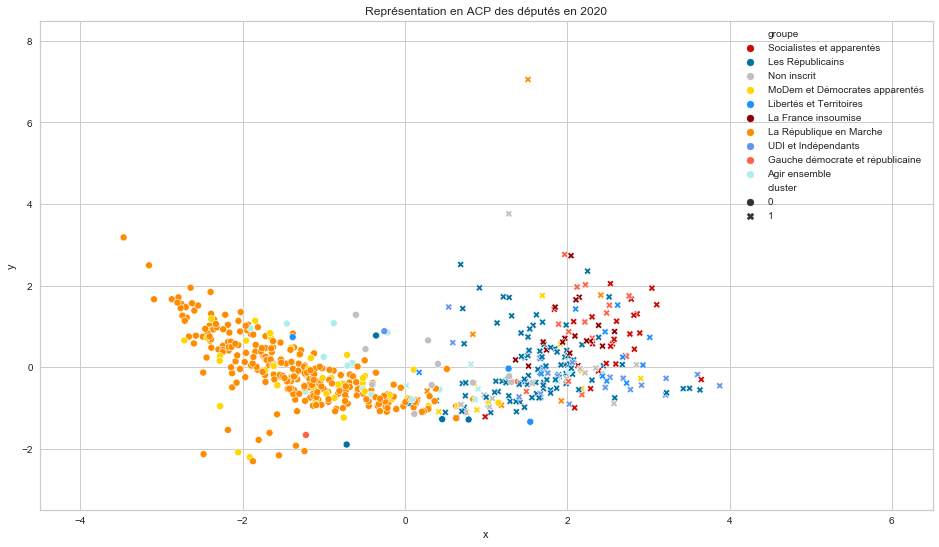

In [23]:
indices_2020 = indices_2020.merge(df_indices[['cluster']], on='idVotant', how='left')
cluster = indices_2020[['cluster']]
indices_2020 = indices_2020.merge(groupe, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2020.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2020.Groupe]
indices_2020['labels'] = labels
indices_2020_acp = indices_2020.drop(['cluster', 'labels','Groupe'], axis=1)

indices_2020_transform = StandardScaler().fit_transform(indices_2020_acp)
pca = PCA(n_components=4).fit(indices_2020_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2020_transform)
x_2020 = resultats_reduced[:, 0]
y_2020 = resultats_reduced[:, 1]

df_plot_2020 = pd.DataFrame(dict(x=x_2020, y=y_2020, label=labels))
df_plot_2020['groupe'] = df_plot_2020['label'].replace(labels_to_groupe)
df_plot_2020 = pd.merge(df_plot_2020, indices_2020[['cluster']].reset_index(drop=True), left_index=True, right_index=True)

plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])
plt.title('Représentation en ACP des députés en 2020')
g = sns.scatterplot(data=df_plot_2020, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)
plt.legend(loc='upper right')
plt.savefig('indices_2020.png')
plt.savefig('2indices_2020.png')
plt.savefig('3indices_2020.png')
plt.savefig('4indices_2020.png')

In [24]:
image = [] 
filename = ['indices_2017.png', '2indices_2017.png', '3indices_2017.png', '4indices_2017.png',
            'indices_2018.png', '2indices_2018.png', '3indices_2018.png', '4indices_2018.png',
            'indices_2019.png', '2indices_2019.png', '3indices_2019.png', '4indices_2019.png',
            'indices_2020.png', '2indices_2020.png', '3indices_2020.png', '4indices_2020.png',] 
for file in filename: 
    image.append(imageio.imread(file)) 
    imageio.mimsave('indices.gif', image)
from IPython.display import Image
display(Image(url='indices.gif'))